In [128]:

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Circle
from scipy.interpolate import CubicSpline
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from scipy.fftpack import fft, ifft, fftfreq

# Plotting parameters
plt.rc("text", usetex=True)
plt.rc("font", family="serif", size=14)
plt.rc("lines", linewidth=2)
plt.rc("axes", grid=False)

In [129]:
plot_frame = True
frame_number = 1
experiment_number = "20250211_083548"


In [130]:

experiment_path = rf"E:\FDL\2D Jet Study Experiments\2025-02-11\{experiment_number}"


results_path = rf"C:\Users\niloy\Google Drive\School Stuff\M.SC Mechanical Engineering\01 - Fluid Dynamics Lab\03 - PDA\01 - 2D Surface Perturbations\Results\{experiment_number}"

obstacle_path = rf"{results_path}\obstacle_data.npy"
free_surface_data = rf"{results_path}\free_surface_data.npy"


In [131]:

obstacle = np.load(obstacle_path)  # Load the saved array
free_surface_all = np.load(free_surface_data)


# Get Obstacle values (only for single obstacle)
x_obs = obstacle[0][0][0]  # Convert to scalar
y_obs = obstacle[0][0][1]  # Convert to scalar
R_obs = obstacle[0][0][2]  # Convert to scalar


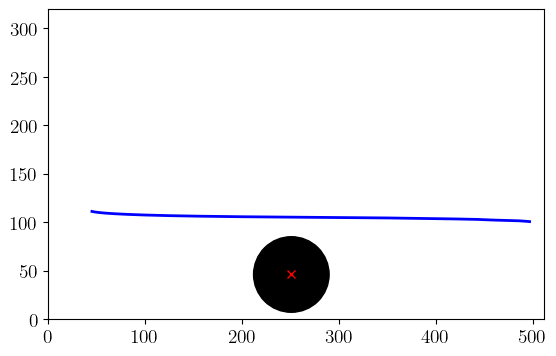

In [132]:

if plot_frame:

    free_surface = free_surface_all[:, :, frame_number]

    fig, ax = plt.subplots()
    ax.plot(free_surface[0], free_surface[1], "b")

    # Create and add the circle patch
    circle = Circle((x_obs, y_obs), R_obs, color="k", fill=True)
    ax.plot(x_obs, y_obs, "xr")
    ax.add_patch(circle)

    ax.set_ylim(0, 320)
    ax.set_xlim(0, 512)
    ax.set_aspect("equal")  # Ensure the circle isn't distorted

    plt.show()


In [133]:
X = free_surface_all[0, :, :]
Y = free_surface_all[1, :, :]
T = X.shape[1]

initial_free_surface = free_surface_all[:, :, 0]
H0 = initial_free_surface[1,0]
r = R_obs / H0
y = (np.mean(Y, axis=0)-y_obs)/H0
T0 = np.min(np.where(y > 1)[0]).item()
t = np.arange(0,T,1)/T0
U0 = H0/T0
A = 2*U0/T0

# Dimensionalize

H0_m = H0 * (15.3/2/R_obs) /1000
T0_s = T0 / 8000
U0_ms = H0_m/T0_s
A_ms2 = 2*U0_ms/T0_s
L = (9.81 + A_ms2) * H0_m /U0_ms**2
Fr = 1/np.sqrt(L)

print(f'''
    Dimensional values
      H0 = {H0_m} m
      T0 = {T0_s} s
      U0 = {U0_ms} m/s
      A = {A_ms2} m/s^2
      L = {L}
      Fr = {Fr}
      
      ''')



    Dimensional values
      H0 = 0.020540566773429695 m
      T0 = 0.01575 s
      U0 = 1.304162969741568 m/s
      A = 165.60799615765941 m/s^2
      L = 2.1184725403073026
      Fr = 0.6870503741897221
      
      


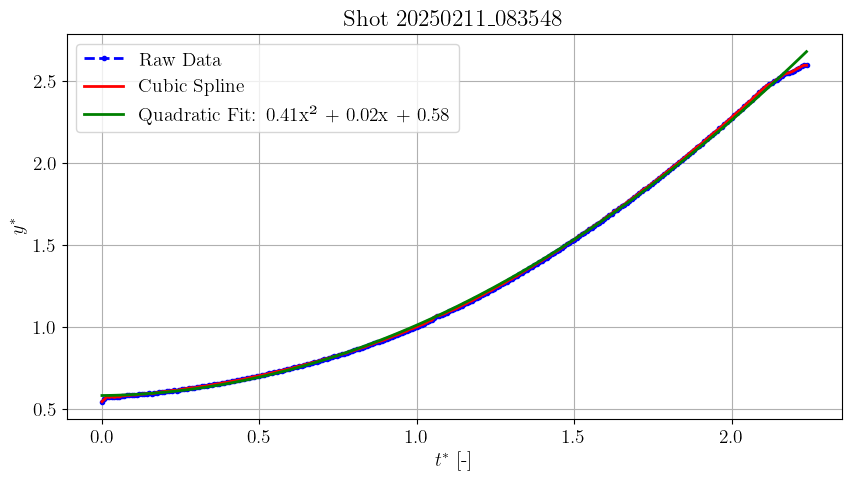

In [134]:
# Clean up values to remove NaN from post processing
t = t[~np.isnan(y)]
y = y[~np.isnan(y)]

y_vs_t = CubicSpline(t, y)  # Fit cubic spline to (t, y)
U_vs_t= y_vs_t.derivative()(t)  # Evaluate derivative at t points
a_vs_t= y_vs_t.derivative(2)(t)  # Evaluate derivative at t points

y_vs_t = CubicSpline(t, y)  # Fit cubic spline to (t, y)

coeffs = np.polyfit(t, y, 2)  # Returns [a, b, c] for ax² + bx + c
quadratic_fit = np.poly1d(coeffs)  # Convert to a polynomial function

# Generate smooth x values for plotting
t_quad = np.linspace(min(t), max(t), 100)
y_quad = quadratic_fit(t_quad)

plt.figure(figsize=(10, 5))
plt.plot(t, y, marker=".", linestyle="--", color="b", label="Raw Data")
plt.plot(t,y_vs_t(t),'r',label = "Cubic Spline")
plt.plot(t_quad, y_quad, label=f"Quadratic Fit: {coeffs[0]:.2f}x² + {coeffs[1]:.2f}x + {coeffs[2]:.2f}", color="green")
plt.xlabel("$t^*$ [-]")
plt.ylabel("$y^*$ ")
plt.title(f"Shot {experiment_number}")
plt.legend()
plt.grid()


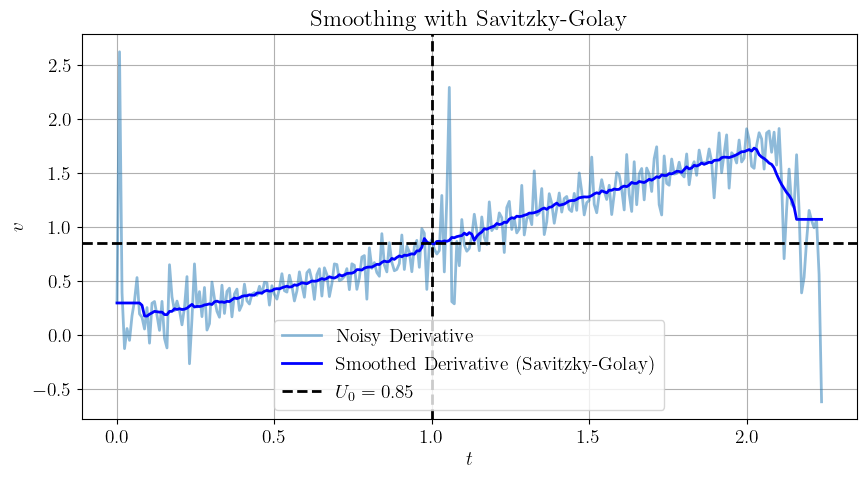

In [138]:

# Assuming U_vs_t is your noisy first derivative (velocity)
U_smooth = savgol_filter(U_vs_t, window_length=20, polyorder=0)  # Adjust window size & polynomial order



U0 = U_smooth[t==1]

plt.figure(figsize=(10,5))
plt.plot(t, U_vs_t, label="Noisy Derivative", alpha=0.5)
plt.plot(t, U_smooth, label="Smoothed Derivative (Savitzky-Golay)", linewidth=2,color = "blue")
# Add a vertical line at t = 1
plt.axvline(1, color='k', linestyle='--',)
plt.axhline(U0, color='k', linestyle='--', label = f"$U_0 = {U0[0]:.2f}$")
plt.legend()
plt.xlabel("$t$")
plt.ylabel("$v$")
plt.title("Smoothing with Savitzky-Golay")
plt.grid()
plt.show()



In [136]:
R_m = 15.3/1000
H0_m = H0/R_obs * R_m
T0_s = T/8000


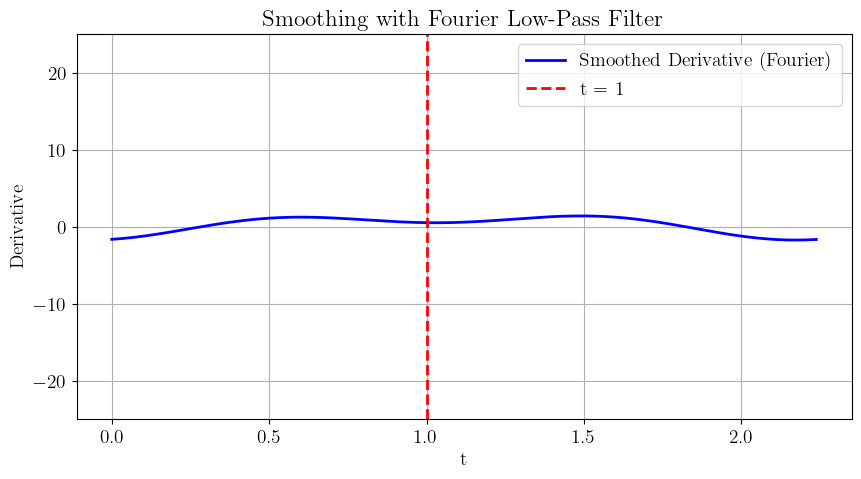

In [137]:

# Define a_vs_t (Noisy Acceleration Data) and t
# Assuming a_vs_t and t are already defined in your environment

# Compute FFT
fft_a = fft(a_vs_t)
freqs = fftfreq(len(t), d=t[1] - t[0])  # Frequency axis

# Low-pass filter: Remove high-frequency components
cutoff_freq = 1 # Adjust based on your data
fft_a[np.abs(freqs) > cutoff_freq] = 0  # Zero out frequencies beyond cutoff

# Inverse FFT to get smoothed acceleration
a_smooth = ifft(fft_a).real

# Plot results
plt.figure(figsize=(10,5))
#plt.plot(t, a_vs_t, label="Noisy Derivative", alpha=0.5)
plt.plot(t, a_smooth, label="Smoothed Derivative (Fourier)", linewidth=2, color="blue")
plt.axvline(x=1, color="red", linestyle="--", label="t = 1")  # Vertical line at t = 1
plt.legend()
plt.xlabel("t")
plt.ylabel("Derivative")
plt.title("Smoothing with Fourier Low-Pass Filter")
plt.grid()
plt.ylim([-25, 25])
plt.show()

# Compute mean of the smoothed derivative
a_mean = np.mean(a_smooth)
